# Yinson Hydromover

### Initial setup

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
sys.path.append("../../")
from vessel_model_tuning_lib import ship_dimensions, maneuvering, resistance, seakeeping, vessel_model_common, actuators

plt.style.use('bmh')

## Vessel data input section
For transparency, all input data used to create the vessel model should be stated in this section. All data used to override default values should also be defined here.

In [2]:
'''
Required data
'''
# All data are in a half load condition

ship_name = 'Hydromover'
Lwl = 18.5 # Length in waterline
B = 8 # Beam in the water line
volume_displacement = 48.261
T = 1.42 # Draft amidships
'''
Additional known data used in the modelling
'''

#Thruster data
max_power = 235e3 # watt per thruster
max_rpm = 750.0
min_rpm = -max_rpm
propeller_diameter = 0.85
propeller_blade_area_ratio = 0.85
propeller_pitch_ratio = 790 / 850 # ~0.93
max_torque_at_propeller = 2814 # Nm
longitudunal_placement_from_stern = 1.2 #m From GA


# Hull data
waterplane_area = 59.3
wetted_area = 118.06
max_section_area = 4.118 # (seems to be for a single hull)
prismatic_coeff = 0.63 # (seems to be for a single hull)
block_coeff = 0.454 # (seems to be for a single hull)
max_section_area_coeff = 0.752 # (seems to be for a single hull)
waterplane_area_coeff = 0.791 # (seems to be for a single hull)
B_single_hull = 2.65
longitudonal_center_of_gravity = 7.0 # m from stern

#Resistance data (TODO)
max_speed_knots = 12.0
cruising_speed_knots = 9.0
res_data = data = pd.read_csv('resistance_data.csv', header=None).to_numpy() # Col 3,4,5 are for half loaded condition
resistance_data_speed_knots = res_data[:, 3]
resistance_data_force = res_data[:, 4]*1e3
resistance_data_power = res_data[:, 5]*1e3

# Hydrostatics
GM_roll = 9.428
GM_pitch = 27.14

'''
Data estimated from tuning or model fitting (TODO)
'''
propeller_geometry = actuators.PropellerGeometry.WAGENINGEN_B4_70_PD08 #Selected based on best fit with bollard pull thrust data from Ferjerederiet
CD_lateral = 0.022 #Extra resistance due to viscous effects (such as submerged transom stern). Use kvlcc2 default
damping_ratio_heave = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_roll = 0.15 #Tunable parameter to get desired damping in the seakeeping decay response
damping_ratio_pitch = 0.3 #Tunable parameter to get desired damping in the seakeeping decay response

### Define the physical constants to be used in the modelling, override defaults if necessary

In [3]:
physical_constants = vessel_model_common.physical_constants()

### Generate ship coefficients based on given main dimension using empirical formulat
If any coefficients are known, they can be overridden in the generated `ship_dimensions` object

In [4]:
ship_dim = ship_dimensions.ShipDimensions(Lwl, B, T, volume_displacement, wetted_area)
ship_dim.C_water_plane = waterplane_area / (Lwl*B)
ship_dim.C_mid_section = 2*max_section_area  / (B*T)
ship_dim.C_prismatic = ship_dim.C_mid_section*ship_dim.C_water_plane
ship_dim.calculate_shape_coefficients()
ship_dim.print()

# Create ship dim object for single hull of the catamaran. Have full wetted area to get total resistance
single_hull_dim = ship_dimensions.ShipDimensions(Lwl, B_single_hull, T, volume_displacement/2, wetted_area)
single_hull_dim.C_water_plane = waterplane_area_coeff
single_hull_dim.C_mid_section = max_section_area_coeff
single_hull_dim.C_prismatic = prismatic_coeff
single_hull_dim.CB = block_coeff
single_hull_dim.print()



Wetted surface:    118.1 m^2
Longitudonal center of gravity:    0.0 m
Longitudonal center of buoyancy:    0.0 m
Block coefficient: 0.2296
Prismatic coefficient: 0.2905
Mid section coefficient: 0.725
Water plane coefficient: 0.4007
Wetted surface:    118.1 m^2
Longitudonal center of gravity:    0.0 m
Longitudonal center of buoyancy:    0.0 m
Block coefficient: 0.454
Prismatic coefficient: 0.63
Mid section coefficient: 0.752
Water plane coefficient: 0.791


## Propeller tuning

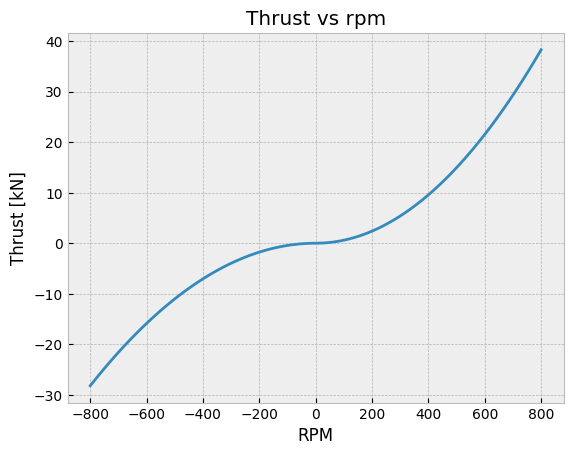

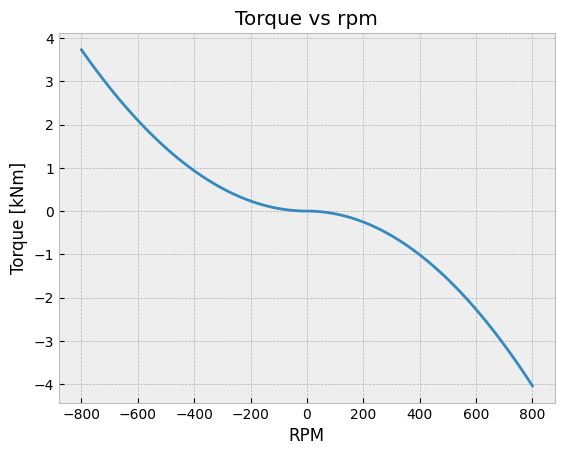

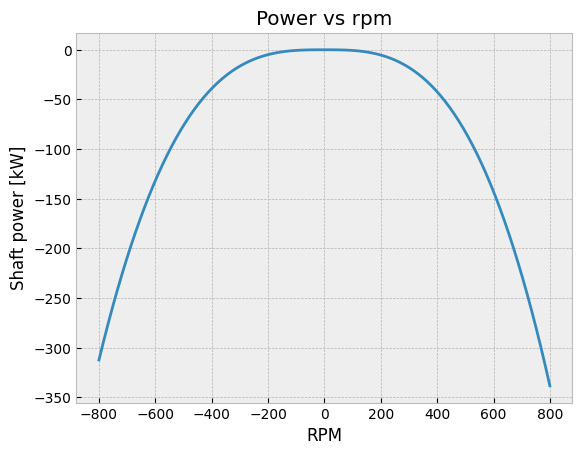

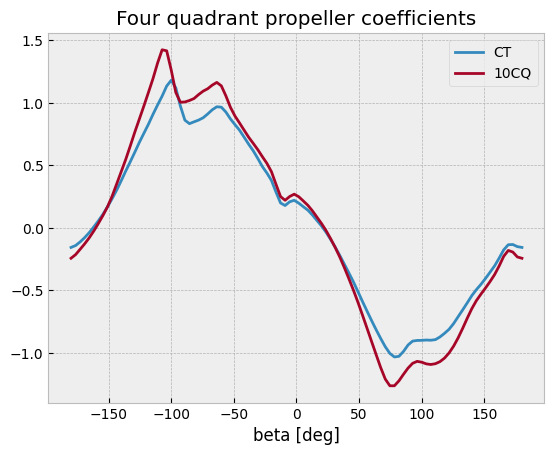

KT0 = <bound method FourQuadrantPropeller.get_KT0 of <vessel_model_tuning_lib.actuators.FourQuadrantPropeller object at 0x7f3fb01123b0>>


In [5]:
pitch_scaling_factor = propeller_pitch_ratio / 0.8 # Linear scaling of thrust/torque coefficients based of ration between PD for propeller geometry and PD for actual propeller
prop = actuators.FourQuadrantPropeller(propeller_geometry, propeller_diameter, pitch_scaling_factor)

#Plot bollard pull thrust
speed = 0.0
rpm_list = np.linspace(min_rpm, max_rpm, 100)
thrust_ax, torque_ax, power_ax = prop.plot_thrust_torque_power_vs_rpm(rpm_list, speed)

#Plot four quadrant curves for propeller geometry
prop.four_quadrant_plot()
plt.show()

print(f"KT0 = {prop.get_KT0()}")


## Straight ahead resistance

### Estimate paramaters for straight ahead resistance

Shape factor, k =  0.0519


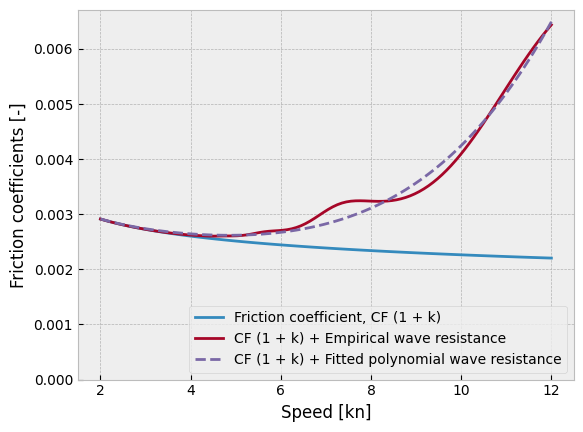

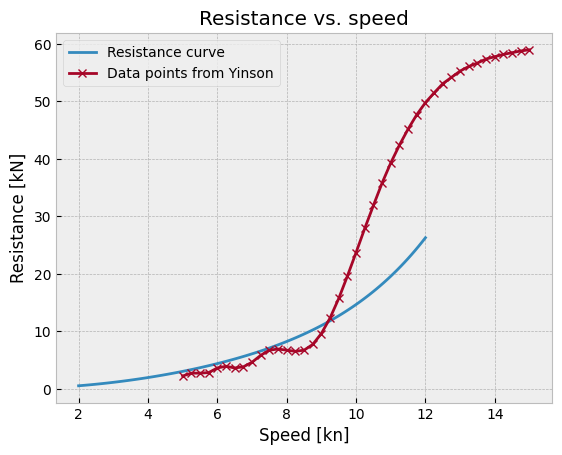

In [6]:
n = 100
U_res_knots = np.linspace(2, max_speed_knots, n)
U_res = U_res_knots * vessel_model_common.knots_to_ms

Fr = U_res / np.sqrt(single_hull_dim.L * physical_constants.g) #Froude number

k = resistance.marintek_shape_factor(single_hull_dim) #Empirical shape factor based on MARINTEK formula

print('Shape factor, k = ', np.round(k, 4))


CR = np.zeros(n)
CF = np.zeros(n)
for i in range(n):
    CR[i] = resistance.holtrop_wave_resistance(single_hull_dim, U_res[i], physical_constants.g, physical_constants.rho) # Resistance coeff due to wave generation (empirical based on Holtrop's method)
    CF[i] = resistance.CF_ITTC(single_hull_dim, U_res[i], physical_constants.nu) * (1 + k) # Resistance coeff due to friction (empirical based on ITTC friction line)
CT = CF + CR
    
CR_m, CR_p = resistance.fit_wave_polynomial(Fr, CR) # Fit resistance model to polynomial model to be used in the FMU
CR_model = resistance.CR_wave_polynomial(Fr, CR_m, CR_p)

#Plot resistance coefficients
plt.figure()
plt.plot(U_res_knots, CF, label='Friction coefficient, CF (1 + k)')
plt.plot(U_res_knots, CF + CR, label='CF (1 + k) + Empirical wave resistance')
plt.plot(U_res_knots, CF + CR_model, '--', label='CF (1 + k) + Fitted polynomial wave resistance')
plt.legend(loc=4)
plt.ylim(0.0, None)
plt.xlabel('Speed [kn]')
plt.ylabel('Friction coefficients [-]')

#Create resistance model (same as used in the FMU)
resistance_model = resistance.Resistance(single_hull_dim, physical_constants)
resistance_model.k          = k
resistance_model.CR_m       = CR_m
resistance_model.CR_p       = CR_p
resistance_model.CD_lateral = CD_lateral

res = np.zeros(n)
for i in range(n):
    res[i] = resistance_model.get_resistance(U_res[i])

#Plot resistance curve together with data points for model fitting (TODO : Add datapoints if available)
plt.figure()
plt.plot(U_res_knots, res/1e3)
plt.title('Resistance vs. speed')
plt.ylabel('Resistance [kN]')
plt.xlabel('Speed [kn]')

ground_thruth_resistance = resistance_data_force
plt.plot(resistance_data_speed_knots, ground_thruth_resistance/1e3, marker='x')
plt.legend(['Resistance curve', 'Data points from Yinson'])



## Maneuvering model

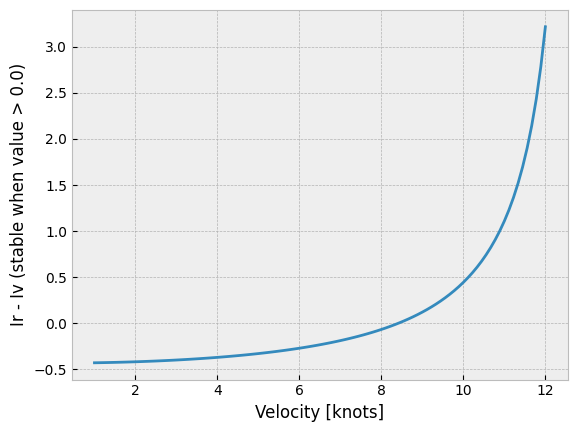

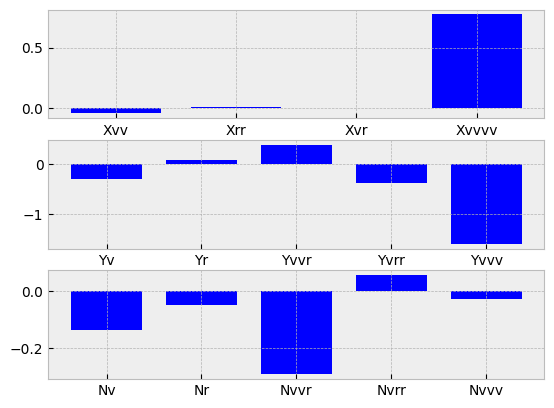

In [7]:
maneuvering_model = maneuvering.MMGModel(ship_dim, physical_constants)

#Check directional stability
U_man = np.linspace(1, max_speed_knots, n) * vessel_model_common.knots_to_ms

stability = np.zeros(n)
for i in range(n):
    stability[i] = maneuvering_model.check_linear_stability(U_man[i])
    
plt.figure()
plt.plot(U_man *vessel_model_common.ms_to_knots, stability)
plt.xlabel('Velocity [knots]')
plt.ylabel('Ir - Iv (stable when value > 0.0)')

#Visualize model parameters
maneuvering_model.plot_model_parameters()

# Seakeeping model

Heave: Natural period:  2.56s, damping ratio: 0.3
Roll: Natural period:  1.90s, damping ratio: 0.15
Pitch: Natural period:  2.27s, damping ratio: 0.3


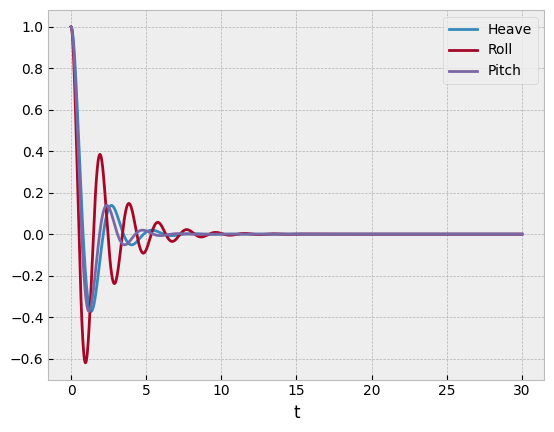

In [8]:
inertias = seakeeping.Inertias(ship_dim, physical_constants)#Set default values for inertias
inertias.set_horizontal_added_mass_from_maneuvering_model(maneuvering_model.added_mass)#Use values from maneuvering model in the horizontal dof's since these are avaiable

waterplane_area = ship_dim.C_water_plane*ship_dim.L*ship_dim.B
hydrostatics = seakeeping.Hydrostatics(GM_roll, GM_pitch, waterplane_area)

damping_ratios = [damping_ratio_heave, damping_ratio_roll, damping_ratio_pitch]

seakeeping_model = seakeeping.Seakeeping(ship_dim, physical_constants, hydrostatics, inertias, damping_ratios)

seakeeping_model.print_seakeeping_data()
seakeeping_model.plot_decay_response()



## Generate XML formatted FMU parameters that can be directly inserted into an OSP config

In [9]:
osp_param_gen = vessel_model_common.OSPParameterGen(ship_dim, physical_constants, maneuvering_model, seakeeping_model, resistance_model, prop)

#hull_maneuvering parameters
hull_maneuvering_params = osp_param_gen.generate_hull_maneuvering_params()
osp_param_gen.write_to_xml(hull_maneuvering_params, ship_name + '_hull_maneuvering_params.xml')
print("hull_maneuvering parameters:")
osp_param_gen.print_params(hull_maneuvering_params)
print("----------------------------------------------------")

#hull_seakeeping parameters
hull_seakeeping_params = osp_param_gen.generate_hull_seakeeping_params()
osp_param_gen.write_to_xml(hull_seakeeping_params, ship_name + '_hull_seakeeping_params.xml')
print("hull_seakeeping parameters:")
osp_param_gen.print_params(hull_seakeeping_params)
print("----------------------------------------------------")

#rigid_body parameters (Simulink version)
rigid_body_params = osp_param_gen.generate_rigid_body_params()
osp_param_gen.write_to_xml(rigid_body_params, ship_name + '_rigid_body_params.xml')
print("rigid_body parameters:")
osp_param_gen.print_params(rigid_body_params)
print("----------------------------------------------------")

#TODO: Add generation of thruster parameters

hull_maneuvering parameters:
Xvv	 -0.04
Xvr	 0.002
Xrr	 0.011
Xvvvv	 0.771
Yv	 -0.315
Yr	 0.083
Yvvv	 -1.607
Yvrr	 -0.391
Yvvr	 0.379
Yrrr	 0.008
Nv	 -0.137
Nr	 -0.049
Nvvv	 -0.03
Nvrr	 0.055
Nvvr	 -0.294
Nrrr	 -0.013
shape_factor	 0.051874
CR_m	 0.116437
CR_p	 4.231902
CD_lateral	 0.022
length	 18.5
depth	 1.42
wetted_surface	 118.06
----------------------------------------------------
hull_seakeeping parameters:
mass	 49509.51207
waterplane_area	 59.3
GM_roll	 9.428
GM_pitch	 27.14
heave_damping	 145974.55981
roll_damping	 415888.435937
pitch_damping	 2856332.743807
----------------------------------------------------
rigid_body parameters:
m	 49509.51207
m_added[1]	 5484.244597
m_added[2]	 55590.297507
m_added[3]	 49707.550118
I[1]	 388154.574629
I[2]	 1059039.406622
I[3]	 1059039.406622
I_added[1]	 31686.087725
I_added[2]	 660840.589732
I_added[3]	 938491.356687
----------------------------------------------------
